In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import itertools

In [2]:
np.random.seed(1)
data = pd.read_csv('C:/Users/moein16/Dropbox/Important Documents/Code/west_End.csv')
data.loc[data['label_cost'] ==0, 'label_cost'] = 0
data.loc[data['label_cost'] > 0, 'label_cost'] = 1

#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data.iloc[:, 0:8] = scaler.fit_transform(data.iloc[:, 0:8])

data = pd.DataFrame(data)



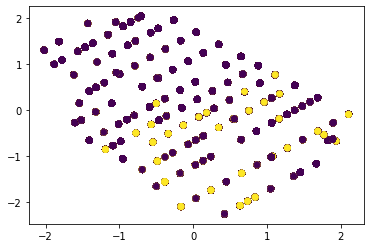

In [3]:
plt.scatter(data['xi_destination'], data['yi_destination'], c=data['label_cost'])

In [4]:
# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# Put data in tensor
inputs = torch.tensor( data.iloc[:, 0:8].values, dtype=torch.float32)
labels = torch.tensor(data.iloc[:, 8].values, dtype=torch.float32).reshape(-1,1)

print( inputs.shape)
print(labels.shape)

# Index training, validation, and test sets
n_train = int(0.6*len(data))
n_valid = int(0.2*len(data))
n_test  = len(data) - n_train - n_valid
train_idx = range(n_train)
valid_idx = range(n_train, n_train+n_valid)
test_idx  = range(n_train+n_valid, len(data))

# Inputs and labels for training, validation, and test sets
inputs_train = inputs[train_idx]
inputs_valid = inputs[valid_idx]
inputs_test  = inputs[test_idx]
labels_train = labels[train_idx]
labels_valid = labels[valid_idx]
labels_test  = labels[test_idx]

# TensorFlow objects
train_data = TensorDataset(inputs_train, labels_train)
valid_data = TensorDataset(inputs_valid, labels_valid)
test_data = TensorDataset(inputs_test, labels_test)

print("Train:", len(train_data))
print("Valid:", len(valid_data))
print("Test:", len(test_data))

torch.Size([360000, 8])
torch.Size([360000, 1])
Train: 216000
Valid: 72000
Test: 72000


In [5]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 20)
    layers = []

    in_features = 8

    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 1, 100)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        #p=trial.suggest_float("dropout_l{}".format(i),0.2,0.5)
        #layers.append(nn.Dropout(p))
        
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers)
def objective(trial):
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 30, 100)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

#    model = NeuralNetwork(input_dim, hidden_dim1, output_dim)
    model=define_model(trial)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    loss_values = []
       
    for epoch in range(num_epochs):
        #total_acc_train = 0
        total_loss_train = 0
        model.train()
        for train_inputs, train_label in train_dataloader:
            train_output = model(train_inputs) 
            train_loss = criterion(train_output, train_label)
            
            total_loss_train += train_loss.item()    
            #acc = (train_output.round() == train_label).sum().item()
            #acc=(train_output.argmax(dim=1) == train_label).sum().item()
            #total_acc_train += acc
            
            optimizer.zero_grad()  
            train_loss.backward()
            optimizer.step()
     #validaation of the model    
        
        model.eval() 
        total_acc_val = 0
        total_loss_val = 0        
        with torch.no_grad():       
            for val_inputs, val_label in valid_dataloader:
                val_output = model(val_inputs.float() )  
                #val_label = val_label.view(-1) 
                val_loss = criterion(val_output, val_label)
                total_loss_val += val_loss.item()
                _, predicted = torch.max(val_output, 1)
                total_acc_val += (predicted == val_label).sum().item()
                
                #acc = (val_output.round() == val_label).sum().item()
                #acc = (val_output.argmax(dim=1)== val_label).sum().item()
                #total_acc_val += acc
            
        accuracy = total_acc_val/len(valid_dataloader)
        valid_loss = total_loss_val / len(valid_dataloader)       
                
    return valid_loss
    
    
    

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)    
    
best_trial = study.best_trial
print('Best trial: ', best_trial.params)
print('Best trial value: ', best_trial.value)

[I 2023-06-16 12:33:57,969] A new study created in memory with name: no-name-12e7291e-4102-4653-bbad-e9b547f80704
C:\Users\moein16\AppData\Local\Temp\ipykernel_15876\4183779174.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-06-16 12:51:04,638] Trial 0 finished with value: 0.1744011341305967 and parameters: {'learning_rate': 0.017199990191471854, 'num_epochs': 75, 'batch_size': 16, 'n_layers': 7, 'n_units_l0': 78, 'n_units_l1': 47, 'n_units_l2': 26, 'n_units_l3': 33, 'n_units_l4': 5, 'n_units_l5': 43, 'n_units_l6': 31}. Best is trial 0 with value: 0.1744011341305967.
[I 2023-06-16 13:12:04,354] Trial 1 finished with value: 0.5060585285425186 and parameters: {'learning_rate': 5.843135738536018e-05, 'num_epochs': 54, 'batch_size': 8, 'n_layers': 6,

[I 2023-06-16 19:56:06,573] Trial 20 finished with value: 0.17801187771610502 and parameters: {'learning_rate': 0.04989113605761551, 'num_epochs': 89, 'batch_size': 16, 'n_layers': 4, 'n_units_l0': 82, 'n_units_l1': 32, 'n_units_l2': 41, 'n_units_l3': 24}. Best is trial 13 with value: 0.16647949154040542.
[I 2023-06-16 20:14:23,371] Trial 21 finished with value: 0.17132080431696442 and parameters: {'learning_rate': 0.018017396858701597, 'num_epochs': 90, 'batch_size': 16, 'n_layers': 5, 'n_units_l0': 93, 'n_units_l1': 51, 'n_units_l2': 18, 'n_units_l3': 70, 'n_units_l4': 95}. Best is trial 13 with value: 0.16647949154040542.
[I 2023-06-16 20:41:32,677] Trial 22 finished with value: 0.1744927611494851 and parameters: {'learning_rate': 0.00940616882739813, 'num_epochs': 92, 'batch_size': 16, 'n_layers': 10, 'n_units_l0': 99, 'n_units_l1': 53, 'n_units_l2': 14, 'n_units_l3': 79, 'n_units_l4': 88, 'n_units_l5': 18, 'n_units_l6': 64, 'n_units_l7': 42, 'n_units_l8': 71, 'n_units_l9': 26}. Be

Best trial:  {'learning_rate': 0.04938195577419754, 'num_epochs': 87, 'batch_size': 16, 'n_layers': 3, 'n_units_l0': 91, 'n_units_l1': 78, 'n_units_l2': 33}
Best trial value:  0.16606151013663556


In [7]:
# Get the best hyperparameters
best_trial = study.best_trial
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
num_epochs = best_trial.params['num_epochs']

# Create an instance of the neural network
model = define_model(best_trial)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Retrain
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

for epoch in range(num_epochs):
        total_acc = 0
        loss_train = 0
        for i, data in enumerate(train_dataloader):
            inputs,label = data                                  
            output = model(inputs) 
            #label = label.view(-1) 
            loss = criterion(output, label)
              
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            loss_train += loss.item() 
            _, predicted = torch.max(output, 1)
            total_acc += (predicted == label).sum().item()


        accuracy = total_acc/len(train_dataloader)
        avg_loss = loss_train / len(train_dataloader)
        #print('Epoch: {}. Loss: {}. '.format(epoch, loss.item()))  
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")



Epoch 1/87 | Train Loss: 0.2736 | Accuracy: 204.0047
Epoch 2/87 | Train Loss: 0.2277 | Accuracy: 204.0047
Epoch 3/87 | Train Loss: 0.2151 | Accuracy: 204.0047
Epoch 4/87 | Train Loss: 0.2080 | Accuracy: 204.0047
Epoch 5/87 | Train Loss: 0.2026 | Accuracy: 204.0047
Epoch 6/87 | Train Loss: 0.1980 | Accuracy: 204.0047
Epoch 7/87 | Train Loss: 0.1948 | Accuracy: 204.0047
Epoch 8/87 | Train Loss: 0.1915 | Accuracy: 204.0047
Epoch 9/87 | Train Loss: 0.1888 | Accuracy: 204.0047
Epoch 10/87 | Train Loss: 0.1859 | Accuracy: 204.0047
Epoch 11/87 | Train Loss: 0.1839 | Accuracy: 204.0047
Epoch 12/87 | Train Loss: 0.1816 | Accuracy: 204.0047
Epoch 13/87 | Train Loss: 0.1791 | Accuracy: 204.0047
Epoch 14/87 | Train Loss: 0.1772 | Accuracy: 204.0047
Epoch 15/87 | Train Loss: 0.1752 | Accuracy: 204.0047
Epoch 16/87 | Train Loss: 0.1734 | Accuracy: 204.0047
Epoch 17/87 | Train Loss: 0.1719 | Accuracy: 204.0047
Epoch 18/87 | Train Loss: 0.1710 | Accuracy: 204.0047
Epoch 19/87 | Train Loss: 0.1686 | Ac

In [9]:
print(avg_loss)

0.13220162715574002


In [10]:
test_dataloader = DataLoader(dataset=test_data, batch_size=4,shuffle=True)
model.state_dict()
model.eval() 

test_loss = 0.0
correct = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
       
        
        # Forward pass
        test_outputs = model(inputs)
        loss = criterion(test_outputs, labels)
        
        # Accumulate the test loss
        test_loss += loss.item()
        
        # Compute the predicted labels
        _, predicted = torch.max(test_outputs, 1)
        
        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()

# Compute the average test loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
accuracy = correct / len(test_dataloader)

# Print the average test loss and accuracy
print(f"Test Loss: {avg_test_loss:.4f} | Accuracy: {accuracy:.4f}")

Test Loss: 0.1675 | Accuracy: 12.7793


In [11]:

from sklearn.metrics import confusion_matrix

y_pred=model(inputs_test)

y_pred=np.where(y_pred>0.5,1,0)

#y_pred.to_csv('y_pred.csv', index=False)
#y_true = labels_test.numpy()

y_true = labels_test.numpy()

# Convert the predicted labels to a Series
y_pred_series = pd.Series(y_pred.flatten(), name='Predicted Labels')

# Create a Series for the true labels
y_true_series = pd.Series(y_true.flatten(), name='True Labels')

# Concatenate the true labels and predicted labels into a DataFrame
result = pd.concat([y_true_series, y_pred_series], axis=1)
result.to_csv('result.csv',index=False)                  
confusion_matrix(y_true, y_pred)


array([[55728,  1779],
       [ 3266, 11227]], dtype=int64)

In [12]:

from sklearn.metrics import accuracy_score
accuracy_score=accuracy_score(y_true, y_pred)
print(accuracy_score)
# Recall
from sklearn.metrics import recall_score
recall_score=recall_score(y_true, y_pred, average=None)
print(recall_score)
# Precision
from sklearn.metrics import precision_score
precision_score=precision_score(y_true, y_pred, average=None)
print(precision_score)

0.9299305555555556
[0.96906464 0.77464983]
[0.94463844 0.86321698]


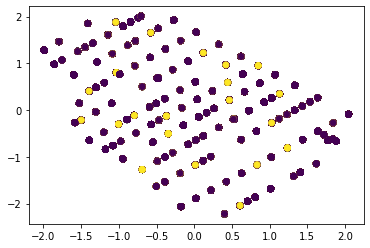

In [13]:
plt.scatter(inputs_test[:,0], inputs_test[:,1], c=y_pred)

# Linear regression

In [18]:
np.random.seed(1)
data = pd.read_csv('C:/Users/moein16/Dropbox/Important Documents/Code/west_End.csv')
data = data[data['label_cost'] != 0]

#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data)

data = pd.DataFrame(data)

# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# Put data in tensor
inputs = torch.tensor( data.iloc[:, 0:8].values, dtype=torch.float32)
labels = torch.tensor(data.iloc[:, 8].values, dtype=torch.float32).unsqueeze(1)

print( labels.shape)

# Index training, validation, and test sets
n_train = int(0.6*len(data))
n_valid = int(0.2*len(data))
n_test  = len(data) - n_train - n_valid
train_idx = range(n_train)
valid_idx = range(n_train, n_train+n_valid)
test_idx  = range(n_train+n_valid, len(data))

# Inputs and labels for training, validation, and test sets
inputs_train = inputs[train_idx]
inputs_valid = inputs[valid_idx]
inputs_test  = inputs[test_idx]
labels_train = labels[train_idx]
labels_valid = labels[valid_idx]
labels_test  = labels[test_idx]

# TensorFlow objects
train_data = TensorDataset(inputs_train, labels_train)
valid_data = TensorDataset(inputs_valid, labels_valid)
test_data = TensorDataset(inputs_test, labels_test)

print("Train:", len(train_data))
print("Valid:", len(valid_data))
print("Test:", len(test_data))

torch.Size([73104, 1])
Train: 43862
Valid: 14620
Test: 14622


## 2. training the network_cross validation

In [19]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 20)
    layers = []

    in_features = 8

    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 1, 100)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        #p=trial.suggest_float("dropout_l{}".format(i),0.2,0.5)
        #layers.append(nn.Dropout(p))
        
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    
    return nn.Sequential(*layers)
def objective(trial):
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 30, 100)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

#    model = NeuralNetwork(input_dim, hidden_dim1, output_dim)
    model=define_model(trial)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    loss_values = []
    for epoch in range(num_epochs):
        # Training
        train_running_loss = 0
        model.train()
        for train_inputs, train_label in train_dataloader:
            train_output = model(train_inputs)    
            train_loss = criterion(train_output, train_label) 
            optimizer.zero_grad()  
            train_loss.backward()
            optimizer.step()
            train_running_loss += train_loss.item()

        # Validation
        model.eval() 
        valid_running_loss = 0.0  
        with torch.no_grad():       
            for valid_inputs, valid_label in valid_dataloader:
                valid_output = model(valid_inputs)
                valid_loss = criterion(valid_output, valid_label)
                valid_running_loss += valid_loss.item()
        valid_loss = valid_running_loss / len(valid_dataloader)
        
        #trial.report(valid_loss, num_epochs)
        #if trial.should_prune():
         #   raise optuna.exceptions.TrialPruned()
        
    return valid_loss

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
                            #, pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=30)    
    
best_trial = study.best_trial
print('Best trial: ', best_trial.params)
print('Best trial value: ', best_trial.value)

[I 2023-06-16 23:42:27,180] A new study created in memory with name: no-name-e66dcdc1-99a8-4ff3-93fa-5748be4b733b
C:\Users\moein16\AppData\Local\Temp\ipykernel_15876\3136670676.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-06-16 23:52:27,562] Trial 0 finished with value: 1.0143281170849727 and parameters: {'learning_rate': 0.02233057412554974, 'num_epochs': 95, 'batch_size': 16, 'n_layers': 8, 'n_units_l0': 30, 'n_units_l1': 49, 'n_units_l2': 3, 'n_units_l3': 26, 'n_units_l4': 65, 'n_units_l5': 49, 'n_units_l6': 3, 'n_units_l7': 40}. Best is trial 0 with value: 1.0143281170849727.
[I 2023-06-17 00:00:42,594] Trial 1 finished with value: 0.20895699125916353 and parameters: {'learning_rate': 0.004390329687689614, 'num_epochs': 48, 'batch_size': 1

[I 2023-06-17 03:10:56,187] Trial 20 finished with value: 0.6682932249859334 and parameters: {'learning_rate': 0.004092351481147106, 'num_epochs': 93, 'batch_size': 16, 'n_layers': 4, 'n_units_l0': 2, 'n_units_l1': 88, 'n_units_l2': 63, 'n_units_l3': 66}. Best is trial 13 with value: 0.1738404868582276.
[I 2023-06-17 03:21:36,767] Trial 21 finished with value: 1.0137010276871907 and parameters: {'learning_rate': 0.0014865947137205964, 'num_epochs': 79, 'batch_size': 16, 'n_layers': 11, 'n_units_l0': 86, 'n_units_l1': 91, 'n_units_l2': 88, 'n_units_l3': 87, 'n_units_l4': 64, 'n_units_l5': 71, 'n_units_l6': 20, 'n_units_l7': 62, 'n_units_l8': 48, 'n_units_l9': 2, 'n_units_l10': 99}. Best is trial 13 with value: 0.1738404868582276.
[I 2023-06-17 03:32:19,487] Trial 22 finished with value: 0.18263756515176996 and parameters: {'learning_rate': 0.002402933743768214, 'num_epochs': 69, 'batch_size': 16, 'n_layers': 9, 'n_units_l0': 91, 'n_units_l1': 71, 'n_units_l2': 84, 'n_units_l3': 89, 'n_u

Best trial:  {'learning_rate': 0.0015691362591477042, 'num_epochs': 71, 'batch_size': 16, 'n_layers': 8, 'n_units_l0': 100, 'n_units_l1': 100, 'n_units_l2': 100, 'n_units_l3': 79, 'n_units_l4': 69, 'n_units_l5': 78, 'n_units_l6': 35, 'n_units_l7': 66}
Best trial value:  0.1738404868582276


## Re_train 

In [20]:
# Get the best hyperparameters
best_trial = study.best_trial
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
num_epochs = best_trial.params['num_epochs']

# Create an instance of the neural network
model = define_model(best_trial)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Retrain
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, label = data
        optimizer.zero_grad()    
        predictions = model(inputs)    
        loss = criterion(predictions, label)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    #if epoch % 10 == 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

Epoch [1/71], Loss: 0.4614
Epoch [2/71], Loss: 0.3361
Epoch [3/71], Loss: 0.3032
Epoch [4/71], Loss: 0.2810
Epoch [5/71], Loss: 0.2696
Epoch [6/71], Loss: 0.2572
Epoch [7/71], Loss: 0.2476
Epoch [8/71], Loss: 0.2374
Epoch [9/71], Loss: 0.2331
Epoch [10/71], Loss: 0.2260
Epoch [11/71], Loss: 0.2199
Epoch [12/71], Loss: 0.2142
Epoch [13/71], Loss: 0.2088
Epoch [14/71], Loss: 0.2051
Epoch [15/71], Loss: 0.2012
Epoch [16/71], Loss: 0.1954
Epoch [17/71], Loss: 0.1929
Epoch [18/71], Loss: 0.1888
Epoch [19/71], Loss: 0.1851
Epoch [20/71], Loss: 0.1803
Epoch [21/71], Loss: 0.1782
Epoch [22/71], Loss: 0.1771
Epoch [23/71], Loss: 0.1725
Epoch [24/71], Loss: 0.1696
Epoch [25/71], Loss: 0.1670
Epoch [26/71], Loss: 0.1664
Epoch [27/71], Loss: 0.1646
Epoch [28/71], Loss: 0.1595
Epoch [29/71], Loss: 0.1593
Epoch [30/71], Loss: 0.1556
Epoch [31/71], Loss: 0.1556
Epoch [32/71], Loss: 0.1532
Epoch [33/71], Loss: 0.1518
Epoch [34/71], Loss: 0.1491
Epoch [35/71], Loss: 0.1474
Epoch [36/71], Loss: 0.1467
E

## Evaluation

In [21]:
test_dataloader = DataLoader(dataset=test_data, batch_size=5,shuffle=True)
model.state_dict()
model.eval() 

test_running_loss = 0.0  
with torch.no_grad():       
    for test_inputs, test_label in test_dataloader:
        test_output = model(test_inputs)
        test_loss= criterion(test_output, test_label)
        test_running_loss += test_loss.item()
    test_loss = test_running_loss / len(test_dataloader)
        
print(test_loss)

0.1852107617045299


C:\Users\moein16\AppData\Local\Temp\ipykernel_15876\108727299.py:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prediction_errors = np.array(prediction_errors)
C:\Users\moein16\AppData\Local\Temp\ipykernel_15876\108727299.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction_errors = np.array(prediction_errors)


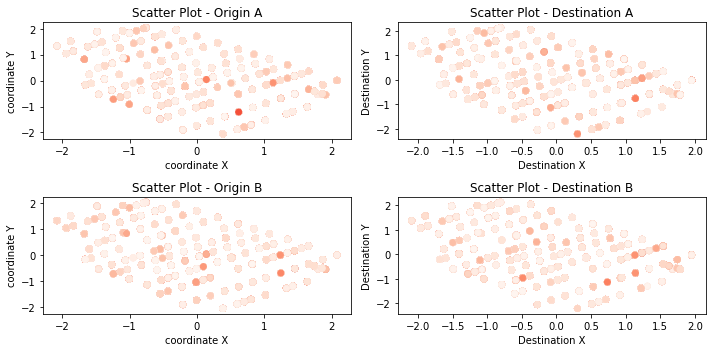

In [22]:
import matplotlib.cm as cm

    
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1)

prediction_errors = []
with torch.no_grad():

    for inputs, labels in test_dataloader:
        inputs = inputs.float()

        # Perform prediction
        predicted_value = model(inputs)
        error = predicted_value - labels.item()
        prediction_errors.append(error)

prediction_errors = np.array(prediction_errors)
Origin_A = []
Destination_A = []
Origin_B = []
Destination_B = []

for inputs, labels in test_dataloader:
    # Access the inputs for each batch
    origin_A_subset = inputs[:, :2]
    destination_A_subset = inputs[:, 2:4]
    origin_B_subset = inputs[:, 4:6]
    destination_B_subset = inputs[:, 6:8]

    Origin_A.append(origin_A_subset)
    Destination_A.append(destination_A_subset)
    Origin_B.append(origin_B_subset)
    Destination_B.append(destination_B_subset)

Origin_A = torch.cat(Origin_A)
Destination_A = torch.cat(Destination_A)
Origin_B = torch.cat(Origin_B)
Destination_B = torch.cat(Destination_B)

data_origin_A = pd.DataFrame(data=Origin_A.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_destination_A = pd.DataFrame(data=Destination_A.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_origin_A['Prediction_Error'] = abs(prediction_errors)
data_destination_A['Prediction_Error'] = abs(prediction_errors)

data_origin_B = pd.DataFrame(data=Origin_B.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_destination_B = pd.DataFrame(data=Destination_B.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_origin_B['Prediction_Error'] = abs(prediction_errors)
data_destination_B['Prediction_Error'] = abs(prediction_errors)


fig, axes = plt.subplots(2, 2, figsize=(10, 5))

cmap_originA = cm.get_cmap('Reds')


# Scatter plot for Origin
axes[0,0].scatter(data_origin_A['coordinate_X'], data_origin_A['coordinate_Y'], c=data_origin_A['Prediction_Error'], cmap=cmap_originA)
axes[0,0].set_xlabel('coordinate X')
axes[0,0].set_ylabel('coordinate Y')
axes[0,0].set_title('Scatter Plot - Origin A')


# Scatter plot for Destination
axes[0,1].scatter(data_destination_A['coordinate_X'], data_destination_A['coordinate_Y'],  c=data_destination_A['Prediction_Error'], cmap=cmap_originA)
axes[0,1].set_xlabel('Destination X')
axes[0,1].set_ylabel('Destination Y')
axes[0,1].set_title('Scatter Plot - Destination A')

axes[1,0].scatter(data_origin_B['coordinate_X'], data_origin_B['coordinate_Y'], c=data_origin_B['Prediction_Error'], cmap=cmap_originA)
axes[1,0].set_xlabel('coordinate X')
axes[1,0].set_ylabel('coordinate Y')
axes[1,0].set_title('Scatter Plot - Origin B')


axes[1,1].scatter(data_destination_B['coordinate_X'], data_destination_B['coordinate_Y'], c=data_destination_B['Prediction_Error'], cmap=cmap_originA)
axes[1,1].set_xlabel('Destination X')
axes[1,1].set_ylabel('Destination Y')
axes[1,1].set_title('Scatter Plot - Destination B')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

-39.022295794388484


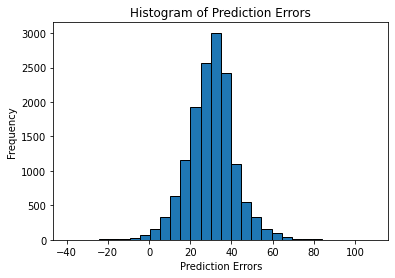

In [27]:
model.eval()
#model = define_model(best_trial)
test_dataloader = DataLoader(dataset=test_data, batch_size=1)

actual_labels = []
prediction_values = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        actual_labels.append(labels.item())

        # Perform prediction
        predicted_value = model(inputs)
        prediction_values.append(predicted_value.item())

actual_labels = np.array(actual_labels)

prediction_values = np.array(prediction_values)

prediction_errors = prediction_values - actual_labels
prediction_errors=(prediction_errors*26.6451227622142)+29.4471807288234
print(min(prediction_errors))
bin=[0.25,0.5, 0.75, 0.9, 1, 1.2,1.8]
plt.hist(prediction_errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

486.75356685695243


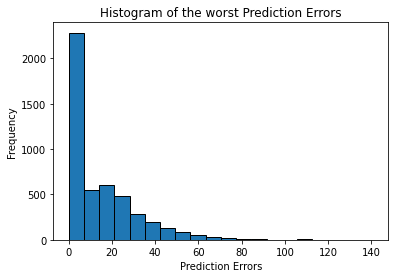

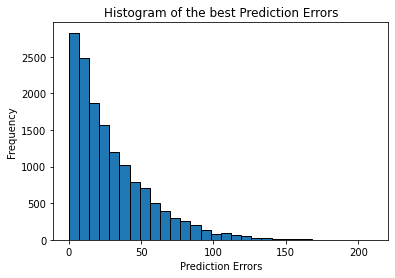

In [30]:
np.set_printoptions(suppress=True)

    
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1)


actual_labels = []
prediction_values = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        actual_labels.append(labels.item())

        # Perform prediction
        predicted_value = model(inputs)
        prediction_values.append(predicted_value.item())

actual_labels = np.array(actual_labels)
actual_labels=(actual_labels*26.6451227622142)+29.4471807288234
prediction_values = np.array(prediction_values)
prediction_values=(prediction_values*20.2853011959177)+23.0581524732843
prediction_errors = (prediction_values - actual_labels)/actual_labels
print(max(prediction_errors))

labels_with_high_errors = actual_labels[(prediction_errors > .5)| (prediction_errors < -.5)]
    #prediction_errors > 1]


plt.hist(labels_with_high_errors, bins=20, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of the worst Prediction Errors')
plt.show()

labels_with_low_errors = actual_labels[(prediction_errors < 0.1)| (prediction_errors > -0.1)]
    #prediction_errors > 1]



plt.hist(labels_with_low_errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of the best Prediction Errors')
plt.show()